<h1><center>ViT test implementation</center></h1>

# Libraries import

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F

from torch import Tensor, nn
from pytorch_model_summary import summary
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

# Image to test

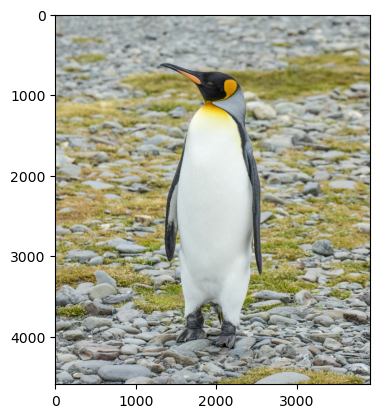

In [22]:
img = Image.open('penguin.jpg')

plt.imshow(img)
plt.show()

In [23]:
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
])

x = transform(img)
print(x.shape)
x = x.unsqueeze(0)
print(x.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


It just adds another artificial dimension for tensor operations.

# Image embedding as encoder input

Let's first run a test encoder

In [26]:
class PatchEmbedding_test(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )  # this breaks down the image in s1xs2 patches, and then flat them

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

In [27]:
print(PatchEmbedding_test()(x).shape)

torch.Size([1, 196, 768])


There are 196 patches of size 768

Let's now test the full encoder (I just added the img size which is not in the original code)

In [29]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )  # this breaks down the image in s1xs2 patches, and then flat them

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)  # prepending the cls token
        x += self.positions
        return x

In [30]:
print(PatchEmbedding()(x).shape)

torch.Size([1, 197, 768])


It's the same shape with an additional patch (still don't know why)

Therefore, it might the cause of a bug in the code.

# Multi-head attention implementation

"The main concept consists of using the product between the queries and the keys to get a sort of understanding of how much each element in a sequence is important to the rest. Such information is later used to scale the values."